In [1]:
# import libraries
# Always run this cell first!
import numpy as np
import pandas as pd

import scipy
import statsmodels.api # appear to need to import the api as well as the library itself for the interpreter to find the modules
import statsmodels as sm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
import plotly.offline
plotly.offline.init_notebook_mode(connected=True) # make plotly work with Jupyter Notebook using CDN

# 3. Hypothesis Testing for Numerical Data

In the [last section](02_Inference_Categorical.ipynb), we learned about the statistical test of hypotheses, which tells us how we can choose between two statistical models. We did this in the context of categorical data, where we hypothesized about population proportions.

In this section, we apply the same theory to numerical data to hypothesize about population means and variances.

### The Palmer Penguins

The [Palmer Penguins dataset](https://github.com/mcnakhaee/palmerpenguins), created by Allison Horst, Alison Hill, and Kristen Gorman, contains physical measurements for 344 adult penguins observed near the Palmer Station in Antarctica. The penguins come from 3 different species: Chinstrap, Gentoo, and Adélie. The data were collected by Kristen Gorman and the Palmer Station LTER Program.

<figure>
    <img src='https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png' alt='Illustration of Chinstrap, Gentoo, and Adélie penguins. Artwork by @allison_horst, used with permission.'>
    <figcaption>Artwork by @allison_horst, used with permission.</figcaption>
</figure>

To load the data, you need to make sure that the `palmerpenguins` package is installed in your environment. We'll load the data as a Pandas data frame named `penguins`.

In [2]:
from palmerpenguins import load_penguins

penguins = load_penguins()
penguins.sample(5).head() # display 5 randomly sampled rows

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
60,Adelie,Biscoe,35.7,16.9,185.0,3150.0,female,2008
101,Adelie,Biscoe,41.0,20.0,203.0,4725.0,male,2009
152,Gentoo,Biscoe,46.1,13.2,211.0,4500.0,female,2007
254,Gentoo,Biscoe,47.2,15.5,215.0,4975.0,female,2009
253,Gentoo,Biscoe,55.9,17.0,228.0,5600.0,male,2009


Using this data, we are going to explore the question of whether the Gentoo penguins at the Palmer Station differ significantly in body mass from the average Gentoo penguin body mass found in the scientific literature. (This example was inspired by [Erin Meyer-Gutbrod](https://github.com/MSCI-599/unit_3_penguins).) 

We can find more information about the worldwide average body mass of the Gentoo penguin by using the [Encyclopedia of Life](https://eol.org/pages/45512076). Based on this page, it looks like the average body mass is 5500 grams. If we let $\mu$ be the average body mass of Gentoo penguins in the Palmer Station area, our hypotheses are

\begin{equation}
H_0: \mu = 5500, \\ H_1: \mu \neq 5500.
\end{equation}

What about the mean body mass for penguins in our sample data?

In [3]:
gentoo = penguins[penguins['species'] == 'Gentoo']
sample_mean = gentoo['body_mass_g'].mean()
print(f"The mean Gentoo body mass in the sample data is {sample_mean:.3f}.")

The mean Gentoo body mass in the sample data is 5076.016.


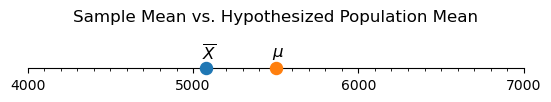

In [4]:
# reference: https://matplotlib.org/stable/gallery/ticks/tick-formatters.html
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(6.4, 0.4))

# create number line by hiding unneeded elements of plot
ax.yaxis.set_major_locator(ticker.NullLocator())
for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)

# set up number line limits
ax.set_xlim(1000*((sample_mean-999)//1000), 1000*((sample_mean+1999)//1000))
ax.set_ylim(0, 1)

# set up number line tick marks
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.xaxis.set_ticks_position('bottom')

# plot sample mean
ax.scatter(sample_mean, 0, s = 75, clip_on=False, zorder=10)
ax.annotate(
    '$\overline{X}$',
    xy = (sample_mean, 0),
    xytext = (-4, 10),
    textcoords = 'offset pixels',
    fontsize = 'large',
)

# plot population mean
ax.scatter(5500, 0, s = 75, clip_on=False, zorder=10)
ax.annotate(
    '$\mu$',
    xy = (5500, 0),
    xytext = (-4, 12),
    textcoords = 'offset pixels',
    fontsize = 'large',
)

ax.set_title('Sample Mean vs. Hypothesized Population Mean', y = 1.25);

Though we could introduce a test based on the standard normal distribution---as we did in the [previous section](02_Inference_Categorical.ipynb)---in the case of numerical data, we are going to utilize the **T-test** instead. As the name suggests, this test is based on the Student's T-distribution. We do this because the T-test will apply both to the cases when the sample size is large and to the cases when it is relatively small.

```{index}Student's T-Distribution
```

## The Student's T-Distribution

When hypothesizing about a population proportion, the null hypothesis gives us a value of $p$ that determines both the mean and standard deviation of the null distribution. On the other hand, the CLT for sample means tells us that as long as $n$ is large enough,

$$\overline{X} \sim N\left(\mu, \frac{\sigma}{\sqrt{n}} \right).$$

Unfortunately, if we make a hypothesis about $\mu$, we are still left with estimating $\sigma$, the population standard deviation. If we have a good estimate for $\sigma$, perhaps from past experiments or expert knowledge, then this is no problem! If we don't know $\sigma$, our best estimate from the data will be to use $S$, the sample standard deviation.

When we standardize the test statistic, we then have

$$ T = \frac{ \overline{X} - \mu } {S / \sqrt{n}} \sim t_{\nu} \qquad \mbox{rather than} \qquad Z = \frac{ \overline{X} - \mu } {\sigma / \sqrt{n}} \sim N(0,1).$$ (t-equation)

The good news is that $T$ has a highly studied distribution called the Student's T-distribution. The T-distribution looks a lot like the standard normal distribution, but it has a wider spread, i.e., more probability in the "tails" of the distribution. This wider spread reflects the extra uncertainty of using the sample standard deviation $S$ in place of the population standard deviation $\sigma$. The T-distribution has only one parameter, called "degrees of freedom", which is represented by the Greek letter $\nu$ (*nu*, pronounced like "new"). This is calculated by subtracting one from the sample size, i.e., $\nu = n - 1$.

We have glossed over an important detail here: The statistic $T = \frac{ \overline{X} - \mu } {S / \sqrt{n}}$ has a T-distribution only if the data in the sample come from a normal distribution. Fortunately, if the sample size is large, we don't need to worry too much about this assumption thanks to the CLT. But if the sample size is small, this becomes especially important! 


Play around with the widget below to get an idea of what the T-distribution looks like compared to the standard normal distribution. Drag the slider to select different degrees of freedom, and click the labels in the legend to hide or show different parts of the graph. Notice how the T-distribution resembles the standard normal distribution more closely as the degrees of freedom increase.

In [5]:
degrees_freedom = np.arange(1, 32, 1)
x = np.linspace(-4, 4, 100)
initial_df_index = 0 # index of degrees of freedom to show initially

# Create figure
fig = go.Figure()

# Use default seaborn palette (reference: https://josephlemaitre.com/2022/06/use-a-seaborn-color-palette-for-plotly-figures/)
plotly_palette = iter([f"rgb({c[0]*256}, {c[1]*256}, {c[2]*256})" for c in sns.color_palette()])
normcolor = next(plotly_palette)
tcolor = next(plotly_palette)

# Add trace for standard normal distribution (always visible)
fig.add_trace(
    go.Scatter(
        visible = True,
        line = { "width": 4 },
        name = "standard normal<br>distribution", # label for legend
        hoverinfo = "x+y",
        marker = { "color": normcolor },
        opacity = 0.7,
        x = x,
        y = scipy.stats.norm.pdf(x)
    )
)

# Add traces for t-distributions
for df in degrees_freedom:
    fig.add_trace(
        go.Scatter(
            visible = True if df == degrees_freedom[initial_df_index] else False,
            line = { "width": 4 },
            name = f"T-distribution<br>(df = {df})", # label for legend
            hoverinfo = "x+y",
            marker = { "color": tcolor },
            opacity = 0.7,
            x = x,
            y = scipy.stats.t.pdf(x, df)
        )
    )
        
# Create steps for the slider to select degrees of freedom
steps = []
for df in degrees_freedom:
    steps.append({
        "method": "update",
        "args": [ # arguments to pass to the update method
            # make only the normal distribution and the t-distribution with df degrees of freedom visible
            { "visible": [True] + [True if i == df else False for i in degrees_freedom] },
        ],
        "label": f"{df}",
    })

# Create a slider using these steps and add it to fig
fig.layout.sliders = [{
    "active": initial_df_index,
    "currentvalue": {"prefix": "Degrees of Freedom: "},
    "pad": {"t": 50},
    "steps": steps,
}]

# Set layout settings
fig.update_layout(
    title = {
        "x": 0.5,
        "text": "T-Distribution vs. Standard Normal Distribution"
    },
    yaxis = {
        "title": "Probability Density",
        #"tickformat": ".2",
    },
    paper_bgcolor = "LightSteelBlue"
)

# Display figure
fig.show()

When $n$ is large ($\ge 30$ or so), then $S$ should be close to $\sigma$, and the T-distribution more or less resembles the standard normal $Z$. So why use T at all? It turns out that the T-distribution can also be useful in cases when we do not have a large enough sample size to use the normal distribution! In this case, as we've already mentioned, we do need one extra assumption: that the population distribution has a normal distribution. This ensures that the sample average will also have a normal distribution. We'll come back to this with a small sample example later in the section.

```{index}T-Test
```

## The T-Test

Now back to our current example: to use a T-test, we need to check the assumption that the underlying data come from a normal distribution. We have $n=119$ observations, which means we're working with a large sample case. Additionally, the histogram of the body mass of the Gentoo penguins is roughly mound-shaped, so using the T-test is appropriate for this situation.

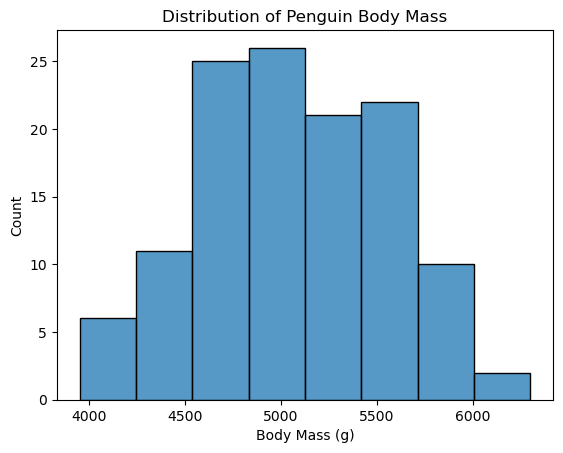

In [6]:
# plot histogram
ax = sns.histplot(
    data = gentoo,
    x = 'body_mass_g',
)
ax.set_xlabel('Body Mass (g)')
ax.set_title('Distribution of Penguin Body Mass');

Now since we know the values of $\overline X$, $S$, and $n$, and the null hypothesis tells us what we assume $\mu$ to be, we can form our test statistic $T$ based on the formula for $T$ [](t-equation) above.

In [7]:
sample = gentoo['body_mass_g'].dropna() # drop missing values
sample_mean = sample.mean()
sample_sd = sample.std()
n = len(sample)
mu_0 = 5500 # hypothesized mean from H_0

T_obs = (sample_mean - mu_0) / (sample_sd / np.sqrt(n))

print(f"The observed value of the test statistic T is {T_obs:.3f}.")

The observed value of the test statistic T is -9.328.


If the population mean really is 5500 g, then we would expect $\overline X$ to be close to 5500 most of the time. Hence, we would expect $T$ to be close to 0 most of the time. 

On the other hand, if the null hypothesis is not true, then we would expect $\overline X$ to be different than 5500, and hence $T$ will likely be much different from 0. Since we made a two-sided hypothesis, values of $T$ that are much bigger than 0 *and* values of $T$ much lower than 0 are both evidence against the null hypothesis.

We observed a very low value of $T$ at -9.365. But again, we only get to observe one value of $T$ and not the entire distribution! Is -9.365 different enough from 0 that we should start doubting that the null hypothesis is true? We can state this question as a probability: If the null hypothesis is really true, what is the chance that we would observe a value of $T$ that is at least as far from 0 as the value we got (-9.365)?

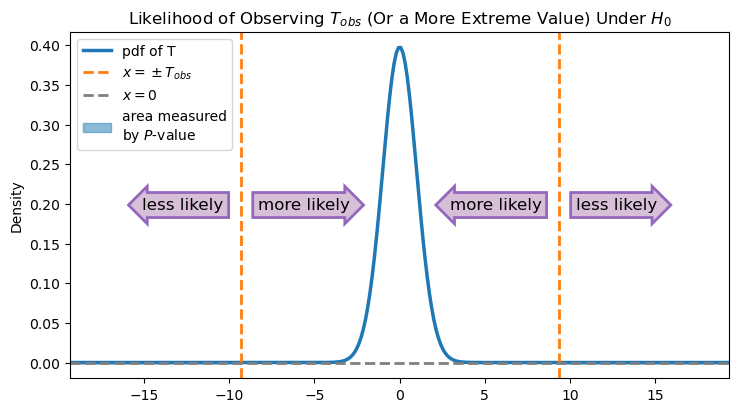

In [8]:
abs_t_obs = abs(T_obs)

# create plot
fig, ax = plt.subplots(figsize=(8.5,4.5))

# use default seaborn palette
palette = sns.color_palette()
pdfcolor = palette[0]
tcolor = palette[1]
arrowcolor = palette[4]

# define x-axis limits
xlim = (-abs_t_obs-10, abs_t_obs+10)

# plot t-distribution pdf (pdf of T)
x = np.linspace(*xlim, 300)
y = scipy.stats.t.pdf(x, df=n-1)
ax.plot(x, y, color=pdfcolor, linewidth=2.5, label='pdf of T')

# set axis limits
ax.set_xlim(*xlim)
half_ylim = sum(ax.get_ylim())/2 # coordinate at middle of y-axis

# plot T_obs and -T_obs
ax.axvline(T_obs, linestyle='dashed', linewidth=2, color=tcolor, label='$x = \pm T_{obs}$')
ax.axvline(-T_obs, linestyle='dashed', linewidth=2, color=tcolor)

# plot x = 0
ax.axhline(0, linestyle='dashed', linewidth=2, color='grey', label='$x = 0$')

# fill area under pdf represented by p-value
ax.fill_between(x, y, where = (x < -abs_t_obs) | (x > abs_t_obs), color=pdfcolor, alpha=0.5, label='area measured\nby $P$-value')

# annotate directions of increasing and decreasing likelihood
ax.text(
    s = 'less likely',
    x = abs_t_obs + 1,
    y = half_ylim,
    ha='left',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'rarrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)
ax.text(
    s = 'more likely',
    x = abs_t_obs - 1,
    y = half_ylim,
    ha='right',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'larrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)
ax.text(
    s = 'more likely',
    x = -abs_t_obs + 1,
    y = half_ylim,
    ha='left',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'rarrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)
ax.text(
    s = 'less likely',
    x = -abs_t_obs - 1,
    y = half_ylim,
    ha='right',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'larrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)

# set up legend, y-axis label, and title
ax.legend(loc='upper left')
ax.set_ylabel('Density')
ax.set_title('Likelihood of Observing $T_{obs}$ (Or a More Extreme Value) Under $H_{0}$');

In [9]:
2 * scipy.stats.t.cdf(T_obs, df=n-1)

6.051182735596651e-16

This is the $P$-value again! Remember how we use the $P$-value to make a decision: If the $P$-value is greater than our specified threshold $\alpha$, then our data is compatible with the null hypothesis, and we **fail to reject the null hypothesis**. If the $P$-value is less than our specified threshold $\alpha$, then our test statistic is incompatible with the null hypothesis, and we will **reject the null hypothesis**.

In this case, the $P$-value is very small. As you can see from the image, the observed value is far from the hypothesized value, so the area under the curve in the "less likely" regions is miniscule. It's so small, in fact, that the area measured by the $P$-value in the  figure above---the area between the density function and the line $x = 0$ that is to the left of $-T_{obs}$ or to the right of $T_{obs}$---isn't even visible at this scale.

Let's zoom in and take a closer look at this area:

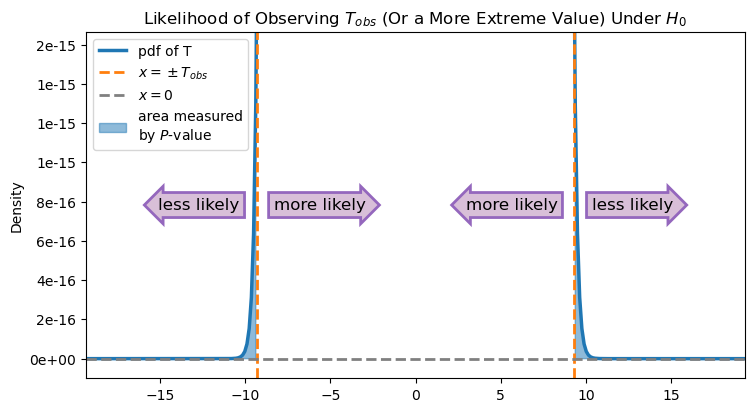

In [10]:
abs_t_obs = abs(T_obs)

# create plot
fig, ax = plt.subplots(figsize=(8.5,4.5))

# use default seaborn palette
palette = sns.color_palette()
pdfcolor = palette[0]
tcolor = palette[1]
arrowcolor = palette[4]

# define x-axis limits
xlim = (-abs_t_obs-10, abs_t_obs+10)

# plot t-distribution pdf (pdf of T)
x = np.linspace(*xlim, 300)
y = scipy.stats.t.pdf(x, df=n-1)
ax.plot(x, y, color=pdfcolor, linewidth=2.5, label='pdf of T')

# set axis limits
ax.set_xlim(*xlim)
ax.set_ylim(-1e-16, scipy.stats.t.pdf(T_obs, df=n-1))
half_ylim = sum(ax.get_ylim())/2 # coordinate at middle of y-axis

# plot T_obs and -T_obs
ax.axvline(T_obs, linestyle='dashed', linewidth=2, color=tcolor, label='$x = \pm T_{obs}$')
ax.axvline(-T_obs, linestyle='dashed', linewidth=2, color=tcolor)

# plot x = 0
ax.axhline(0, linestyle='dashed', linewidth=2, color='grey', label='$x = 0$')

# fill area under pdf represented by p-value
ax.fill_between(x, y, where = (x < -abs_t_obs) | (x > abs_t_obs), color=pdfcolor, alpha=0.5, label='area measured\nby $P$-value')

# annotate directions of increasing and decreasing likelihood
ax.text(
    s = 'less likely',
    x = abs_t_obs + 1,
    y = half_ylim,
    ha='left',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'rarrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)
ax.text(
    s = 'more likely',
    x = abs_t_obs - 1,
    y = half_ylim,
    ha='right',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'larrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)
ax.text(
    s = 'more likely',
    x = -abs_t_obs + 1,
    y = half_ylim,
    ha='left',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'rarrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)
ax.text(
    s = 'less likely',
    x = -abs_t_obs - 1,
    y = half_ylim,
    ha='right',
    va='center',
    size = 12,
    bbox = { 'boxstyle': 'larrow', 'facecolor': 'thistle', 'edgecolor': arrowcolor, 'linewidth': 2 }
)

# set up legend, axis labels and tickmarks, and title
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0e}')) # use exponent notation
ax.legend(loc='upper left')
ax.set_ylabel('Density')
ax.set_title('Likelihood of Observing $T_{obs}$ (Or a More Extreme Value) Under $H_{0}$');

As this graph shows, the area measured by the $P$-value is quite small (note the range of the $y$-axis).

Since the $P$-value is so small, we choose to reject the null hypothesis. There is evidence that the Gentoo penguins in this area are smaller than the average Gentoo penguin.

Why the big difference? Probably the Encyclopedia of Life body mass trait is specifically for adult Gentoo penguins, and our observations contain younger penguins. If we wanted to make a stronger, publishable conclusion we could use this as a jumping off point for further research.

If we were writing this test for a publication we could use language like this: "We conducted a one-sample t-test to compare the body mass of Gentoo penguins measured at the Palmer Station with the theoretical mean adult Gentoo body mass of 5500 g pulled from the Encyclopedia of Life trait bank. The penguin body mass measurements in this study were significantly smaller than the theoretical mean ($p=6.05 \times 10^{-16}$)."



### The T-Test in Python

Fortunately, Python has many of these statistical tests built in, so we don't have to calculate it all from scratch every time. In this case, we use the `scipy.stats` library, which includes the T-test as `ttest_1samp`. Here is code that performs the same test we just did. Verify that the answers match what we computed above!

In [11]:
result = scipy.stats.ttest_1samp(
    a = sample,
    popmean = 5500, # null hypothesis: mean is 0
    alternative = 'two-sided',
)
print(f"T-test for mean: test statistic is {result.statistic:.3f} with {n-1} degrees of freedom.\nP-value is {result.pvalue:.3f}.")

T-test for mean: test statistic is -9.328 with 122 degrees of freedom.
P-value is 0.000.


The test again says that there is evidence that the population mean really is different from 5500. So what value will it take? To answer that, we can return to the confidence interval, this time calculated based on the T-distribution. How you do this might depend on what kind of software you are running.

Run the following code to check the version of `scipy` that you have installed.

In [12]:
print(scipy.__version__)

1.10.1


If your version of `scipy` is 1.10.0 or greater, you can compute the confidence interval by using the `confidence_interval` function associated with the result of the t-test we just ran:

In [13]:
# works for versions of scipy >= 1.10.0
confidence_level = 0.95
(lower_ci, upper_ci) = result.confidence_interval(confidence_level) # use the result object from the t-test
print(f"95% confidence interval is ({lower_ci:.3f}, {upper_ci:.3f}).")

95% confidence interval is (4986.034, 5165.998).


If your version of `scipy` is less than 1.10.0, you can compute the confidence interval by using the `t.interval` function instead. (It also works for versions greater than or equal to 1.10.0.) This function is similar to the `norm.interval` function we used [earlier](01_Foundations.ipynb):

In [14]:
# works for versions of scipy < 1.10.0
confidence_level = 0.95
(lower_ci, upper_ci) = scipy.stats.t.interval(
    confidence_level,
    df = n - 1, # degrees of freedom of test statistic
    loc = sample_mean, # mean of test statistic
    scale = sample_sd/np.sqrt(n) # standard deviation of test statistic
)
print(f"95% confidence interval is ({lower_ci:.3f}, {upper_ci:.3f}).")

95% confidence interval is (4986.034, 5165.998).


We have 95% confidence that the average mass of Gentoo penguins in the Palmer Station area is between about 4986 and 5165 grams, much lower than the null hypothesis from before.

### Exercise 3.1

Repeat the test above for the bill length of Gentoo penguins. This is found in the variable `bill_length_mm`.

1. Find the average bill length for Gentoo penguins from the [Encyclopedia of Life](https://eol.org/pages/45512076). Use this information to form null and alternative hypotheses, making sure to note the units.
2. What is the sample size you have? Does the distribution of bill lengths appear to meet the normality assumption needed to perform the T-test?
3. Perform the test and report the test statistic and $P$-value.
4. What do you conclude? If you find a significant difference, give a confidence interval for average bill length.

```{index}Two-Sample T-Test
```

## Two-Sample T-Test

We can also use the T-test to examine the difference between two population means. Typically, this is done to find out if two populations have the same mean or not.

We can return to our Palmer Penguins example and look at whether the Adélie and Chinstrap penguins from this area have the same average body mass.

Letting $\mu_1$ be the average body mass of Adélie penguins and $\mu_2$ be the average body mass of Chinstrap penguins in the Palmer station area, our hypotheses are

\begin{equation}
H_0: \mu_1 - \mu_2 = 0, \\ H_1: \mu_1 - \mu_2 \neq 0.
\end{equation}

Let's look at our samples:

In [15]:
adelie = penguins[penguins['species'] == 'Adelie']
chinstrap = penguins[penguins['species'] == 'Chinstrap']

print(f"The mean Adélie body mass in the sample data is {adelie['body_mass_g'].mean():.3f}.")
print(f"The mean Chinstrap body mass in the sample data is {chinstrap['body_mass_g'].mean():.3f}.")

The mean Adélie body mass in the sample data is 3700.662.
The mean Chinstrap body mass in the sample data is 3733.088.


These are slightly different, but are they enough different for us to reject the null hypothesis? We need a test statistic to quantify this.

```{index}Test Statistic
```

### The Test Statistic

When the sample sizes $n_1$ and $n_2$ are large enough (typically both $n_1 \geq 30$ and $n_2 \geq 30$), we have

\begin{equation}
    \overline{X}_1 - \overline{X}_2 \sim N \left( \mu_1 - \mu_2, \sqrt{ \frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2} } \right),
\end{equation}

and hence

\begin{equation}
    \frac{\overline{X}_1 - \overline{X}_2 - (\mu_1 - \mu_2)}{ \sqrt{ \frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2} }} \sim N(0,1).
\end{equation}

Just as before, the null hypothesis will tell us about $\mu_1-\mu_2$, but not about $\sigma_1$ and $\sigma_2$, so we'll estimate them from the data using $S_1$ and $S_2$. Making that substitution for the standard deviations, we have a T-distribution:

\begin{equation}
    \frac{\overline{X}_1 - \overline{X}_2 - (\mu_1 - \mu_2)}{ \sqrt{ \frac{S_1^2}{n_1} + \frac{S_2^2}{n_2} }} \sim t_{\nu},
\end{equation}

where $\nu$ represents the degrees of freedom. The exact value of $\nu$ will be calculated by something called Welch's method, but we can let the software handle that details of the computation. You can keep in mind the intuition that if $S_1 \approx S_2$, then $\nu$ will be about $n_1 + n_2 - 2$. On the other hand, if $S_1$ and $S_2$ are very different, then $\nu \approx \min({n_1, n_2})$.

Now that we have two separate samples, the T-distribution requires that *both* come from normal distributions. There are sophisticated ways to check this, but we will just visually assess the histograms.

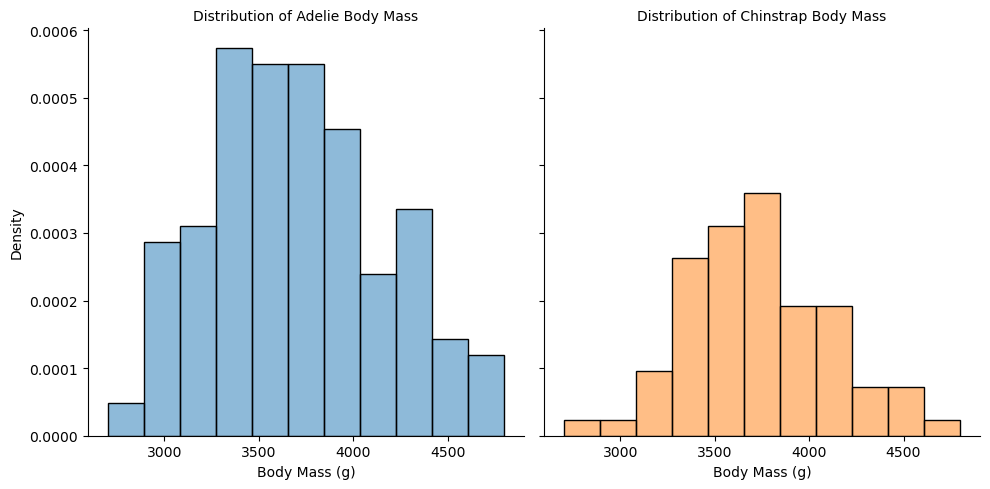

In [16]:
# plot histograms of adelie and chinstrap body mass, faceted by species
facetgrid = sns.displot(
    data = pd.concat([adelie, chinstrap]),
    x = 'body_mass_g',
    hue = 'species',
    col = 'species',
    kind = 'hist',
    stat = 'density',
    legend = False,
)
facetgrid.set_titles('Distribution of {col_name} Body Mass')
facetgrid.set_xlabels('Body Mass (g)');

These look appropriately normal-ish, and the large sample gives us extra wiggle room in the assumptions of the T-test. Moreover, the distributions don't look too different, so we might start to expect that the true difference in means really is 0. So let's perform the test!

The function we will use is a function from `statsmodels` called `ttest_ind`. To use this function, we first need to create a `CompareMeans` object from our two samples. After we've done that, we will be able to call the `ttest_ind` function on this object to perform the actual T-test.

We set the argument `value` equal to the difference of means under our null hypothesis. We set the argument `alternative` to "two-sided" to indicate that we have an two-sided alternative hypothesis. (Other possible values are "larger" and "smaller".) Finally, we set the argument `usevar` to "unequal" to make sure that Welch's method is used to calculate the degrees of freedom.

In [17]:
# set up our two samples (removing all observations with missing values)
sample1 = adelie['body_mass_g'].dropna()
sample2 = chinstrap['body_mass_g'].dropna()

# create a CompareMeans object from the two samples
cm = sm.stats.weightstats.CompareMeans.from_data(sample1, sample2)

# perform the two-sample t-test
(stat, pval, df) = cm.ttest_ind(
    value = 0, # null hypothesis: difference in means is 0
    alternative = 'two-sided', # two-sided alternative hypothesis
    usevar = 'unequal', # perform Welch's t-test
)

print(f'Results of T-test: test statistic is {stat:.3f} with {df:.3f} degrees of freedom.\nP-value is {pval:.3f}.')

Results of T-test: test statistic is -0.543 with 152.455 degrees of freedom.
P-value is 0.588.


We do not find any evidence of a difference in average body mass between these two species, so we fail to reject the null hypothesis.

In this situation, we've failed to reject the null hypothesis, so we are not necessarily interested in computing a confidence interval for this difference (since we already suspect it to be 0). However, for future reference, here is how to compute a confidence interval associated with this test.

In [18]:
conflevel = 0.95

# compute confidence interval, using the same CompareMeans object as before
(lower, upper) = cm.tconfint_diff(
    alpha = 1-conflevel,
    alternative = 'two-sided',
    usevar = 'unequal', # perform Welch's t-test
)
print(f'{int(conflevel*100)}% confidence interval is ({lower:.3f}, {upper:.3f}).')

95% confidence interval is (-150.385, 85.533).


Note that this confidence interval contains 0. Since we have 95% confidence that the difference in the average mass of Adélie and Chinstrap penguins in the Palmer Station area is in this interval, this confirms our conclusion that we have no evidence to reject the null hypothesis.

### Large Sample vs. Small Sample

Why do we need the extra assumption of a normally distributed population in the case of a small sample? In non-technical terms, because we have less information in the data, we need more information from elsewhere (in this case, assumptions) to be able to make conclusions.

In the large sample case, the Central Limit Theorem tells us that $\overline{X}$ is normal. In the small sample case, if the sample comes from a normally distributed population, then $\overline{X}$ will again be normal.

Below you can find plots of the sampling distribution of sample averages from both normal and non-normal distributions, each with a population mean of 1 and a standard deviation of 2. The top row looks at small samples (size $n=10$), one from a non-normal distribution (left) and the other from a normal distribution (right). We take the average and "studentize" according to the formula for $T$ [](t-equation) above.

Look first at the upper left plot. The histogram of small-sample averages from the non-normal distribution do not fit well with a T-distribution on 9 degrees of freedom. However, the small-sample averages from the normal distribution in the upper right plot do!

In the bottom row you can find histograms of simulated large sample averages ($n=50$), overlaid with the density function for a T-distribution on 49 degrees of freedom. The sample averages from both the non-normal (lower left) and normal (lower right) distributions end up fitting well with the T-distribution.

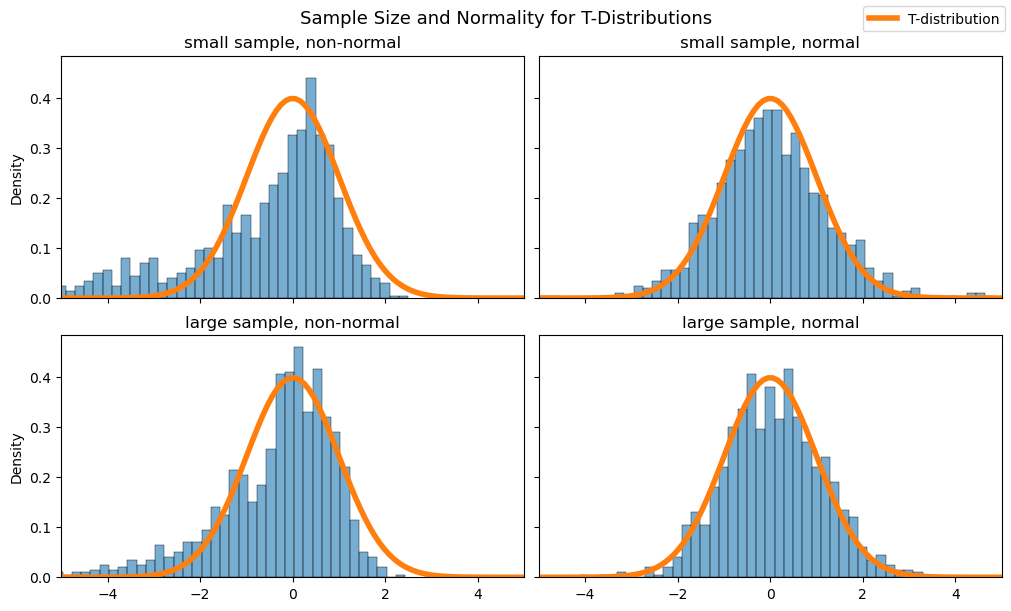

In [19]:
## Show four plots:
## Top left: sampling distribution of small-sample averages from non-normal distribution
## Top right: sampling distribution of small-sample averages from normal distribution
## Bottom left: sampling distribution of large-sample averages from non-normal distribution
## Bottom right: sampling distribution of large-sample averages from normal distribution

def studentize(sample, pop_mean):
    return ( sample.mean() - pop_mean ) / (sample.std() / np.sqrt(len(sample)))

# top to bottom, left to right
sample_means = pd.DataFrame(
    np.array([
        [studentize(scipy.stats.gamma.rvs(a=0.25, scale=4.0, size = 10), 1.0) for i in range(1,1000)],
        [studentize(scipy.stats.norm.rvs(loc=1.0, scale=2.0, size = 10), 1.0) for i in range(1,1000)],
        [studentize(scipy.stats.gamma.rvs(a=0.25, scale=4.0, size = 50), 1.0) for i in range(1,1000)],
        [studentize(scipy.stats.norm.rvs(loc=1.0, scale=2.0, size = 50), 1.0) for i in range(1,1000)],
    ])
).T
titles = [
    [ "small sample, non-normal", "small sample, normal" ],
    [ "large sample, non-normal", "large sample, normal"]
]

# use default seaborn palette
palette = iter(sns.color_palette())
histcolor = next(palette)
tcolor = next(palette)

fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,6), layout='constrained')

# plot histogram
for i in range(0,2):
    for j in range(0,2):
        # get simulated data to plot
        plot_data = sample_means[2*i+j]
        # plot histogram
        sns.histplot(
            ax = axs[i,j],
            data = plot_data,
            stat = 'density',
            color = histcolor,
            linewidth = 0.3,
            alpha = 0.6,
            binwidth = 0.2,
        )
        # plot T-distribution
        x = np.linspace(-5, 5, 100)
        axs[i,j].plot(
            x,
            scipy.stats.t.pdf(x, df=len(plot_data) - 1),
            color = tcolor, 
            linewidth = 4,
            label = 'T-distribution' if i == 0 and j == 0 else '', # label only first t-distribution in legend
        )
        axs[i,j].set_xlim([-5,5])
        axs[i,j].set_title(titles[i][j])
        axs[i,j].set_xlabel('')
fig.legend(loc='upper right')
fig.suptitle("Sample Size and Normality for T-Distributions", fontsize = 13);

This shows us that, in order to use the T-test with a small sample, it's necessary to assume that our data comes from a normal distribution. But how we can tell if this assumption is true? This is a nuanced question. Because you don't have much data to start with, it's difficult to draw strong conclusions about the distribution it came from! Some textbooks will simply tell you to look for rules of thumb: as long as there are no outliers, or the graph looks roughly "mound-shaped", you're ok to proceed with the test. There are even hypothesis tests to quantify this or more sophisticated visuals to use, but they are outside of the scope of this chapter.

### Robustness to Assumptions

Statisticians have determined that the T-test is fairly "robust" to the normality assumptions. In simple terms, robustness means that you can still trust the results of the test, even if your assumptions are only approximately met. In this case, if your data comes from something that is close to normal, the T-test will still work properly. If that feels too imprecise, that's ok! It can take some time to develop your understanding and intuition for this.

## Exercise 3.2

The [Framingham Heart Study](https://en.wikipedia.org/wiki/Framingham_Heart_Study) is an ongoing study of cardiovascular health in the United States. The initial study followed over 5,000 volunteers from  Framingham, Massachusetts, USA over the course of several decades, and it still continues today. The study led to important findings in many areas, including a link between cholesterol and heart disease. (This exercise was inspired by an assignment from UC Berkeley's [Data 8](http://data8.org/).)

We load in the data below from the file `framingham.csv` (click [here](framingham.csv) to download a copy). There are a number of different interesting variables to explore, but we will focus on exploring total cholesterol levels (`TOTCHOL`) versus the occurence of heart disease (`ANYCHD`). The variable `ANYCHD` takes the value `0` if the patient does not have heart disease and the value `1` if they do.

In [20]:
framingham = pd.read_csv("framingham.csv")
framingham.head()

,AGE,SYSBP,DIABP,TOTCHOL,CURSMOKE,DIABETES,GLUCOSE,DEATH,ANYCHD
0,39,106.0,70.0,195.0,0,0,77.0,0,1
1,46,121.0,81.0,250.0,0,0,76.0,0,0
2,48,127.5,80.0,245.0,1,0,70.0,0,0
3,61,150.0,95.0,225.0,1,0,103.0,1,0
4,46,130.0,84.0,285.0,1,0,85.0,0,0


We want to determine if there is a difference in average cholesterol levels between people with heart disease and those without. 

1. State the hypotheses being tested.
2. Describe the assumptions of the T-test and comment on if they are valid for this example.
3. Compute the test statistic and $P$-value.
4. What is your conclusion?
5. Give a confidence interval for the difference in average total cholesterol.